<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#RNN-à-partir-de-caractères" data-toc-modified-id="RNN-à-partir-de-caractères-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>RNN à partir de caractères</a></span></li><li><span><a href="#Préparation-des-données" data-toc-modified-id="Préparation-des-données-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Préparation des données</a></span></li><li><span><a href="#Création-du-RNN" data-toc-modified-id="Création-du-RNN-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Création du RNN</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Évaluation" data-toc-modified-id="Évaluation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Évaluation</a></span></li><li><span><a href="#Visualizing-memorization" data-toc-modified-id="Visualizing-memorization-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Visualizing memorization</a></span></li></ul></div>

# RNN à partir de caractères

Dans ce TP, nous allons définir notre propre RNN en créant une classe RNN qui hérite de l'objet nn.Module de PyTorch.

# Préparation des données

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Russian.txt', 'data/names/English.txt', 'data/names/German.txt', 'data/names/Japanese.txt', 'data/names/Polish.txt', 'data/names/French.txt', 'data/names/Korean.txt', 'data/names/Chinese.txt', 'data/names/Vietnamese.txt', 'data/names/Italian.txt', 'data/names/Spanish.txt', 'data/names/Czech.txt', 'data/names/Arabic.txt', 'data/names/Scottish.txt', 'data/names/Dutch.txt', 'data/names/Greek.txt', 'data/names/Portuguese.txt', 'data/names/Irish.txt']
Slusarski


In [2]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [3]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


# Création du RNN

<img src="images/rnn_a_definir.png" width=300>

In [4]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [24]:
input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)



In [6]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9562, -2.8321, -2.7705, -2.8851, -2.9330, -2.9005, -2.8837, -2.8485,
         -2.8667, -2.9058, -2.8861, -2.8395, -2.9783, -2.9334, -2.9684, -2.8874,
         -2.9010, -2.8731]], grad_fn=<LogSoftmaxBackward>)


# Training

In [7]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('German', 2)


In [8]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Arabic / line = Mustafa
category = German / line = Wolff
category = Spanish / line = Tapia
category = Italian / line = Lippi
category = English / line = Hopwood
category = Japanese / line = Ienari
category = English / line = Olding
category = Japanese / line = Hirase
category = Russian / line = Hitrovo
category = Chinese / line = Ping


In [9]:
criterion = nn.NLLLoss()


In [10]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [11]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 14s) 3.3056 Laar / Chinese ✗ (Dutch)
10000 10% (0m 27s) 2.4365 Dasaev / Japanese ✗ (Russian)
15000 15% (0m 41s) 2.7992 Neil / German ✗ (Irish)
20000 20% (0m 55s) 0.6113 Rudawski / Polish ✓
25000 25% (1m 10s) 1.5610 Charron / French ✓
30000 30% (1m 24s) 0.4321 Altimari / Italian ✓
35000 35% (1m 37s) 1.1071 Alcheri / Italian ✓
40000 40% (1m 51s) 1.9532 Bonheur / Arabic ✗ (French)
45000 45% (2m 6s) 0.7203 Bleier / German ✓
50000 50% (2m 21s) 0.4863 Qiao / Chinese ✓
55000 55% (2m 36s) 2.0591 Karl / Arabic ✗ (Dutch)
60000 60% (2m 50s) 2.0289 Parris / Greek ✗ (French)
65000 65% (3m 4s) 0.8272 Bao / Chinese ✓
70000 70% (3m 18s) 1.3499 Shalhoub / Arabic ✓
75000 75% (3m 32s) 0.2587 Castro / Portuguese ✓
80000 80% (3m 45s) 2.9537 Denend / English ✗ (Dutch)
85000 85% (3m 59s) 0.7454 Astbury / English ✓
90000 90% (4m 13s) 0.2565 Salvaggi / Italian ✓
95000 95% (4m 27s) 0.7820 Soares / Portuguese ✓
100000 100% (4m 41s) 2.1866 Visnap / Czech ✗ (Russian)


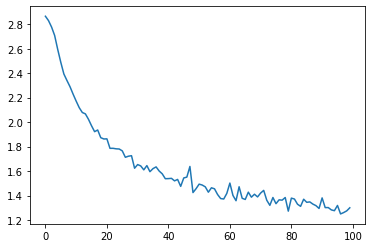

In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

# Évaluation

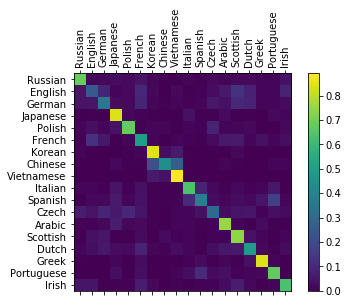

In [14]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()


In [15]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.19) Russian
(-2.06) Czech
(-3.87) English

> Jackson
(-0.28) Scottish
(-2.49) Russian
(-2.49) English

> Satoshi
(-0.78) Japanese
(-1.25) Arabic
(-2.44) Italian


# Visualizing memorization

pred: 5 French
GT: 5 French


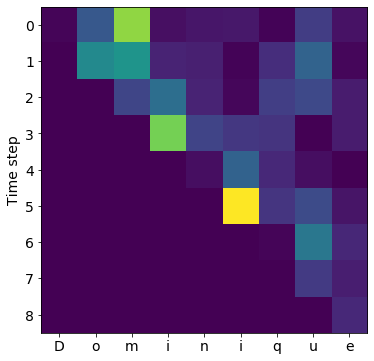

In [119]:
# https://distill.pub/2019/memorization-in-rnns/

from torch.autograd import Variable
import torch.autograd
import numpy as np

# nom = 'Dovesky'
# nom = 'Jackson'
# nom = 'Mohammed'
# nom = 'Sébastien'
nom = 'Dominique'
# nom='Thomas'

category_index = 5

line_tensor = lineToTensor(nom)
# print(line_tensor.size())
# print(line_tensor[0,0])
line_tensor.requires_grad_()

gradient_groundtruth_list = []
hidden = rnn.initHidden()
for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)
    g_groundtruth = torch.autograd.grad(output[0, category_index], line_tensor, retain_graph=True)[0].data
    gradient_groundtruth_list.append(g_groundtruth)
#     print(i, g.size(), g)
    
topv, topi = output.topk(1, 1, True)
category_index_predicted = topi[0][0].item()
print('pred: %i %s' %(category_index_predicted, all_categories[category_index_predicted]))
print('GT: %i %s' %(category_index, all_categories[category_index]))

gradient_pred_list = []
hidden = rnn.initHidden()
for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)
    g = torch.autograd.grad(output[0, category_index_predicted], line_tensor, retain_graph=True)[0].data
    gradient_pred_list.append(g)


# On calcule la "connectivity"
# https://discuss.pytorch.org/t/newbie-getting-the-gradient-with-respect-to-the-input/12709/2
# g = torch.autograd.grad(output[0,category_index], line_tensor, retain_graph=True)[0].data
# print(g.size())
# g = torch.autograd.grad(outputs[:,0,category_index], line_tensor, retain_graph=True)[0].data

connectivity = np.zeros((line_tensor.size()[0],line_tensor.size()[0]))

for i in range(line_tensor.size()[0]):
    char_index = letterToIndex(nom[i])
#     print(i, g[i,0,char_index])
    connectivity[:,i] = np.abs(gradient_groundtruth_list[i][:, 0, char_index].detach().cpu().numpy())
#     print(nom[i], connectivity[:,i])
    

plt.figure(figsize=(8,6))
plt.imshow(connectivity)
plt.ylabel("Time step", fontsize=14)
toto = plt.yticks(ticks=range(len(nom)), fontsize=14)
toto = plt.xticks(ticks=range(len(nom)), labels=list(nom), fontsize=14)

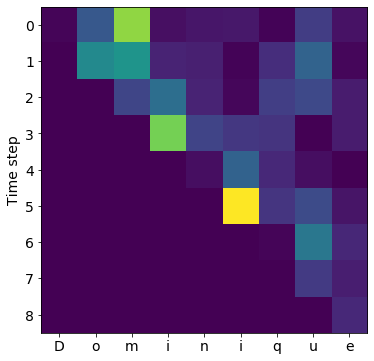

In [120]:
connectivity = np.zeros((line_tensor.size()[0],line_tensor.size()[0]))

for i in range(line_tensor.size()[0]):
    char_index = letterToIndex(nom[i])
#     print(i, g[i,0,char_index])
    connectivity[:,i] = np.abs(gradient_pred_list[i][:, 0, char_index].detach().cpu().numpy())
#     print(nom[i], connectivity[:,i])

plt.figure(figsize=(8,6))
plt.imshow(connectivity)
plt.ylabel("Time step", fontsize=14)
toto = plt.yticks(ticks=range(len(nom)), fontsize=14)
toto = plt.xticks(ticks=range(len(nom)), labels=list(nom), fontsize=14)

In [77]:
torch.autograd.grad?

In [27]:
all_categories

['Russian',
 'English',
 'German',
 'Japanese',
 'Polish',
 'French',
 'Korean',
 'Chinese',
 'Vietnamese',
 'Italian',
 'Spanish',
 'Czech',
 'Arabic',
 'Scottish',
 'Dutch',
 'Greek',
 'Portuguese',
 'Irish']